In [184]:
import numpy as np
import pandas as  pd
import tensorflow as tf
from tensorflow import keras
#import keras
import matplotlib.pyplot as plt 
from tensorflow.keras import layers
from sklearn import *
import math
from sklearn.preprocessing import OrdinalEncoder
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,10)
from sklearn.preprocessing import MinMaxScaler


## Import Data


In [185]:
local_path = "insurance.csv"
data = pd.read_csv(local_path)

In [186]:
data

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


In [187]:
data_np = data.values
y = data_np[:,(-1)]
X = data.drop(columns=["charges"]).values

In [188]:
X

array([[19, 'female', 27.9, 0, 'yes', 'southwest'],
       [18, 'male', 33.77, 1, 'no', 'southeast'],
       [28, 'male', 33.0, 3, 'no', 'southeast'],
       ...,
       [18, 'female', 36.85, 0, 'no', 'southeast'],
       [21, 'female', 25.8, 0, 'no', 'southwest'],
       [61, 'female', 29.07, 0, 'yes', 'northwest']], dtype=object)

In [189]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.4, shuffle=True)

In [190]:
# prepare input data
def prepare_inputs(X_train, X_test):
    oe = OrdinalEncoder()
    oe.fit(X_train)
    X_train_enc = oe.transform(X_train)
    X_test_enc = oe.transform(X_test)
    return X_train_enc, X_test_enc

X_train_enc_col, X_test_enc_col = prepare_inputs(X_train[:,(1,3,4,5)], X_test[:,(1,3,4,5)])

In [191]:
## prepare input data
#def prepare_inputs(X_train, X_test):
#    oe = OrdinalEncoder()
#    oe.fit(X_train)
#    X_train_enc = oe.transform(X_train)
#    X_test_enc = oe.transform(X_test)
#    return X_train_enc, X_test_enc
#
#X_train_enc_col, X_test_enc_col = prepare_inputs(X_train[:,(1,4,5)], X_test[:,(1,4,5)])

In [192]:
X_train[:,(1,3,4,5)] = X_train_enc_col

X_test[:,(1,3,4,5)] = X_test_enc_col



In [193]:
def minmax(X) :
    
    return (X - X.min())/(X.max()-X.min())


In [194]:

X_train[:,0] = minmax(X_train[:,0])
X_test[:,0] = minmax(X_test[:,0])

X_train[:,2] = minmax(X_train[:,2])
X_test[:,2] = minmax(X_test[:,2])

X_train[:,3] = minmax(X_train[:,3])
X_test[:,3] = minmax(X_test[:,3])

In [195]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(802, 6)
(802,)
(536, 6)
(536,)


In [196]:
X_train = np.delete(X_train, 2, 1)
X_test = np.delete(X_test, 2, 1)

In [198]:
X_train

array([[0.6086956521739131, 0.0, 0.0, 0.0, 1.0],
       [0.7608695652173914, 1.0, 0.4, 0.0, 0.0],
       [0.13043478260869565, 0.0, 0.0, 0.0, 3.0],
       ...,
       [0.8913043478260869, 0.0, 0.0, 0.0, 0.0],
       [0.2826086956521739, 0.0, 0.4, 0.0, 2.0],
       [0.3695652173913043, 0.0, 0.0, 0.0, 0.0]], dtype=object)

In [199]:
X_train.astype('float32')

array([[0.6086956 , 0.        , 0.        , 0.        , 1.        ],
       [0.76086956, 1.        , 0.4       , 0.        , 0.        ],
       [0.13043478, 0.        , 0.        , 0.        , 3.        ],
       ...,
       [0.8913044 , 0.        , 0.        , 0.        , 0.        ],
       [0.2826087 , 0.        , 0.4       , 0.        , 2.        ],
       [0.36956522, 0.        , 0.        , 0.        , 0.        ]],
      dtype=float32)

In [200]:
X_train = tf.convert_to_tensor(X_train.astype('float32'))
y_train = tf.convert_to_tensor(y_train.astype('float32'))
X_test = tf.convert_to_tensor(X_test.astype('float32'))
y_test = tf.convert_to_tensor(y_test.astype('float32'))


## Create a sampling layer


In [201]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim)) # Parametrization trick
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon 

## Build the encoder


In [202]:
latent_dim = 3 # Latent Space dimension on the bottleneck
input_dim = X_train.shape[1]
Leaky_ReLu = keras.layers.LeakyReLU(alpha=0.01)

encoder_inputs = keras.Input(shape=( input_dim, ))
x = layers.Dense(3, activation=Leaky_ReLu)(encoder_inputs)

z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 5)]          0           []                               
                                                                                                  
 dense_11 (Dense)               (None, 3)            18          ['input_9[0][0]']                
                                                                                                  
 z_mean (Dense)                 (None, 3)            12          ['dense_11[0][0]']               
                                                                                                  
 z_log_var (Dense)              (None, 3)            12          ['dense_11[0][0]']               
                                                                                            

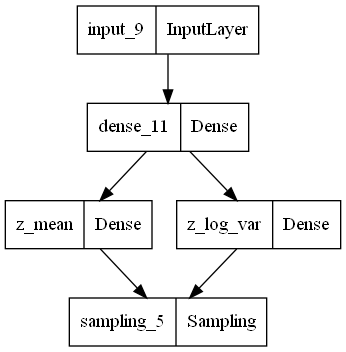

In [203]:
from keras.utils.vis_utils import plot_model
keras.utils.plot_model(encoder, to_file='encoder.png')

## Build the decoder


In [204]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(3,  activation=Leaky_ReLu)(latent_inputs)
decoder_outputs = layers.Dense(1, activation="linear")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 3)]               0         
                                                                 
 dense_12 (Dense)            (None, 3)                 12        
                                                                 
 dense_13 (Dense)            (None, 1)                 4         
                                                                 
Total params: 16
Trainable params: 16
Non-trainable params: 0
_________________________________________________________________


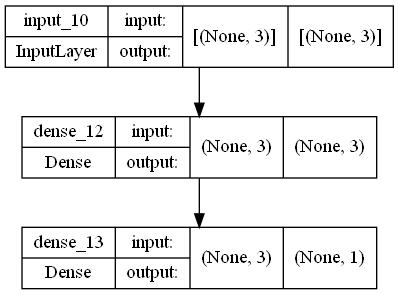

In [205]:
plot_model(decoder,  show_shapes=True, show_layer_names=True)

## Define the VAE as a Model with a custom train_step


In [206]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, KL_hyperparam, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.KL_hyperparam = KL_hyperparam
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")  #MEAN? 
        self.reconstruction_loss_tracker = keras.metrics.Mean(    #MEAN? 
            name="MSE"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")   #MEAN? 
        
        self.total_loss_tracker_val = keras.metrics.Mean(name="total_loss_val")  #MEAN? 
        self.reconstruction_loss_tracker_val = keras.metrics.Mean(    #MEAN? 
            name="MSE_val"
        )
        self.kl_loss_tracker_val = keras.metrics.Mean(name="kl_loss_val")   #MEAN? 

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
            
            self.total_loss_tracker_val,
            self.reconstruction_loss_tracker_val,
            self.kl_loss_tracker_val
        ]

    def train_step(self, data):
        x, y_true = data
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(x)
            reconstruction = self.decoder(z)
            reconstruction_loss = keras.losses.mean_squared_error(y_true, reconstruction)
            
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            #kl_loss = tf.reduce_mean(kl_loss, axis=1)
            
            total_loss = reconstruction_loss + kl_loss * self.KL_hyperparam
            
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        
        self.total_loss_tracker.update_state(total_loss)
        
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        
        self.kl_loss_tracker.update_state(kl_loss)
        
        return {
            "loss": self.total_loss_tracker.result(),
            "MSE": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

    def test_step(self, data):
        # Unpack the data
        x, y_true = data
        # Compute predictions
        z_mean, z_log_var, z = self.encoder(x)
        reconstruction = self.decoder(z)
        
        ## Losses
        reconstruction_loss = keras.losses.mean_squared_error(y_true, reconstruction)
        
        kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
        kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
        
        total_loss = reconstruction_loss + kl_loss * self.KL_hyperparam

        # Updates the metrics tracking the loss
        self.total_loss_tracker_val.update_state(total_loss)
        
        self.reconstruction_loss_tracker_val.update_state(reconstruction_loss)
        
        self.kl_loss_tracker_val.update_state(kl_loss)
        
        return {
            "loss_val": self.total_loss_tracker_val.result(),
            "MSE_val": self.reconstruction_loss_tracker_val.result(),
            "kl_loss_val": self.kl_loss_tracker_val.result(),
        }



    def call(self, inputs):

        z_mean, z_log_var, z = self.encoder(inputs)
        reconstruction = self.decoder(z)
                


        return reconstruction
    


## Train the VAE

In [207]:
vae = VAE(encoder, decoder, 1)

In [208]:
from keras.optimizers import adam_v2
adam = adam_v2.Adam()




In [209]:
vae.compile(optimizer=adam)

In [210]:
history = vae.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=150, batch_size=8 )

Epoch 1/200
101/101 [==============================] - 1s 3ms/step - loss: 344059405.4902 - MSE: 322842848.0000 - kl_loss: 1.4947 - val_loss_val: 322315456.0000 - val_MSE_val: 322315456.0000 - val_kl_loss_val: 2.6009
Epoch 2/200
101/101 [==============================] - 0s 2ms/step - loss: 325908832.0000 - MSE: 322821856.0000 - kl_loss: 4.6941 - val_loss_val: 322281248.0000 - val_MSE_val: 322281248.0000 - val_kl_loss_val: 8.6308
Epoch 3/200
101/101 [==============================] - 0s 2ms/step - loss: 316781147.9216 - MSE: 322758208.0000 - kl_loss: 19.8236 - val_loss_val: 322167776.0000 - val_MSE_val: 322167744.0000 - val_kl_loss_val: 44.9417
Epoch 4/200
101/101 [==============================] - 0s 2ms/step - loss: 326006887.8431 - MSE: 322328064.0000 - kl_loss: 554.6359 - val_loss_val: 320587840.0000 - val_MSE_val: 320584064.0000 - val_kl_loss_val: 3895.3108
Epoch 5/200
101/101 [==============================] - 0s 2ms/step - loss: 356251838.1176 - MSE: 314363424.0000 - kl_loss: 25

Epoch 37/200
101/101 [==============================] - 0s 3ms/step - loss: 266051762.6667 - MSE: 271995776.0000 - kl_loss: 921751.0000 - val_loss_val: 270462368.0000 - val_MSE_val: 269339040.0000 - val_kl_loss_val: 1123303.1250
Epoch 38/200
101/101 [==============================] - 0s 3ms/step - loss: 275916508.5490 - MSE: 271643968.0000 - kl_loss: 882980.5000 - val_loss_val: 276455552.0000 - val_MSE_val: 275394912.0000 - val_kl_loss_val: 1060666.8750
Epoch 39/200
101/101 [==============================] - 0s 3ms/step - loss: 281806562.8235 - MSE: 267919056.0000 - kl_loss: 976317.6875 - val_loss_val: 274258304.0000 - val_MSE_val: 273242304.0000 - val_kl_loss_val: 1015993.3125
Epoch 40/200
101/101 [==============================] - 0s 3ms/step - loss: 282440317.0196 - MSE: 271866912.0000 - kl_loss: 861606.8125 - val_loss_val: 270816192.0000 - val_MSE_val: 269864096.0000 - val_kl_loss_val: 952091.8750
Epoch 41/200
101/101 [==============================] - 0s 3ms/step - loss: 281740373

Epoch 73/200
101/101 [==============================] - 0s 3ms/step - loss: 151821335.6078 - MSE: 161397936.0000 - kl_loss: 114534.0234 - val_loss_val: 162561920.0000 - val_MSE_val: 162448576.0000 - val_kl_loss_val: 113348.5312
Epoch 74/200
101/101 [==============================] - 0s 3ms/step - loss: 139217591.9216 - MSE: 158987584.0000 - kl_loss: 94334.3203 - val_loss_val: 161502576.0000 - val_MSE_val: 161392064.0000 - val_kl_loss_val: 110459.7031
Epoch 75/200
101/101 [==============================] - 0s 3ms/step - loss: 177175649.2549 - MSE: 157477888.0000 - kl_loss: 95813.3984 - val_loss_val: 160911104.0000 - val_MSE_val: 160809072.0000 - val_kl_loss_val: 102064.5703
Epoch 76/200
101/101 [==============================] - 0s 3ms/step - loss: 154627557.5294 - MSE: 156441296.0000 - kl_loss: 79851.2812 - val_loss_val: 159976784.0000 - val_MSE_val: 159884720.0000 - val_kl_loss_val: 92045.0078
Epoch 77/200
101/101 [==============================] - 0s 3ms/step - loss: 165148949.1765 -

101/101 [==============================] - 0s 3ms/step - loss: 152842342.6667 - MSE: 145718976.0000 - kl_loss: 18202.5938 - val_loss_val: 152338048.0000 - val_MSE_val: 152318096.0000 - val_kl_loss_val: 19956.9355
Epoch 110/200
101/101 [==============================] - 0s 3ms/step - loss: 144554165.7255 - MSE: 146955760.0000 - kl_loss: 18023.2637 - val_loss_val: 152215264.0000 - val_MSE_val: 152195440.0000 - val_kl_loss_val: 19805.9082
Epoch 111/200
101/101 [==============================] - 0s 3ms/step - loss: 137398174.3529 - MSE: 146058880.0000 - kl_loss: 17088.3359 - val_loss_val: 152114144.0000 - val_MSE_val: 152095328.0000 - val_kl_loss_val: 18810.5781
Epoch 112/200
101/101 [==============================] - 0s 3ms/step - loss: 153321157.4118 - MSE: 145822224.0000 - kl_loss: 16945.1602 - val_loss_val: 152038320.0000 - val_MSE_val: 152019424.0000 - val_kl_loss_val: 18919.1895
Epoch 113/200
101/101 [==============================] - 0s 3ms/step - loss: 133188559.9216 - MSE: 1441811

101/101 [==============================] - 0s 3ms/step - loss: 154382042.9804 - MSE: 144187952.0000 - kl_loss: 9692.2158 - val_loss_val: 150554560.0000 - val_MSE_val: 150544640.0000 - val_kl_loss_val: 9955.0361
Epoch 146/200
101/101 [==============================] - 0s 3ms/step - loss: 146822659.1373 - MSE: 143720656.0000 - kl_loss: 9632.9590 - val_loss_val: 150452736.0000 - val_MSE_val: 150443040.0000 - val_kl_loss_val: 9698.3408
Epoch 147/200
101/101 [==============================] - 0s 3ms/step - loss: 145523341.8824 - MSE: 144352544.0000 - kl_loss: 9250.1465 - val_loss_val: 150400320.0000 - val_MSE_val: 150390768.0000 - val_kl_loss_val: 9572.4600
Epoch 148/200
101/101 [==============================] - 0s 3ms/step - loss: 137665579.8431 - MSE: 144295792.0000 - kl_loss: 9368.9863 - val_loss_val: 150418400.0000 - val_MSE_val: 150408992.0000 - val_kl_loss_val: 9451.3604
Epoch 149/200
101/101 [==============================] - 0s 3ms/step - loss: 144813317.0980 - MSE: 143266416.0000 

101/101 [==============================] - 0s 3ms/step - loss: 136894840.2745 - MSE: 142137280.0000 - kl_loss: 7197.7681 - val_loss_val: 149816944.0000 - val_MSE_val: 149809632.0000 - val_kl_loss_val: 7257.1792
Epoch 182/200
101/101 [==============================] - 0s 2ms/step - loss: 146769832.3922 - MSE: 142702336.0000 - kl_loss: 7242.1504 - val_loss_val: 149835680.0000 - val_MSE_val: 149828400.0000 - val_kl_loss_val: 7271.8472
Epoch 183/200
101/101 [==============================] - 0s 2ms/step - loss: 145422791.6078 - MSE: 143446480.0000 - kl_loss: 7184.5645 - val_loss_val: 149770848.0000 - val_MSE_val: 149763632.0000 - val_kl_loss_val: 7180.7256
Epoch 184/200
101/101 [==============================] - 0s 2ms/step - loss: 141424385.3333 - MSE: 142864176.0000 - kl_loss: 7076.8735 - val_loss_val: 149850928.0000 - val_MSE_val: 149843728.0000 - val_kl_loss_val: 7199.1606
Epoch 185/200
101/101 [==============================] - 0s 3ms/step - loss: 142500690.7451 - MSE: 142778400.0000 

In [211]:
samp_num = 1

In [212]:
print(history.history.keys())

dict_keys(['loss', 'MSE', 'kl_loss', 'val_loss_val', 'val_MSE_val', 'val_kl_loss_val'])


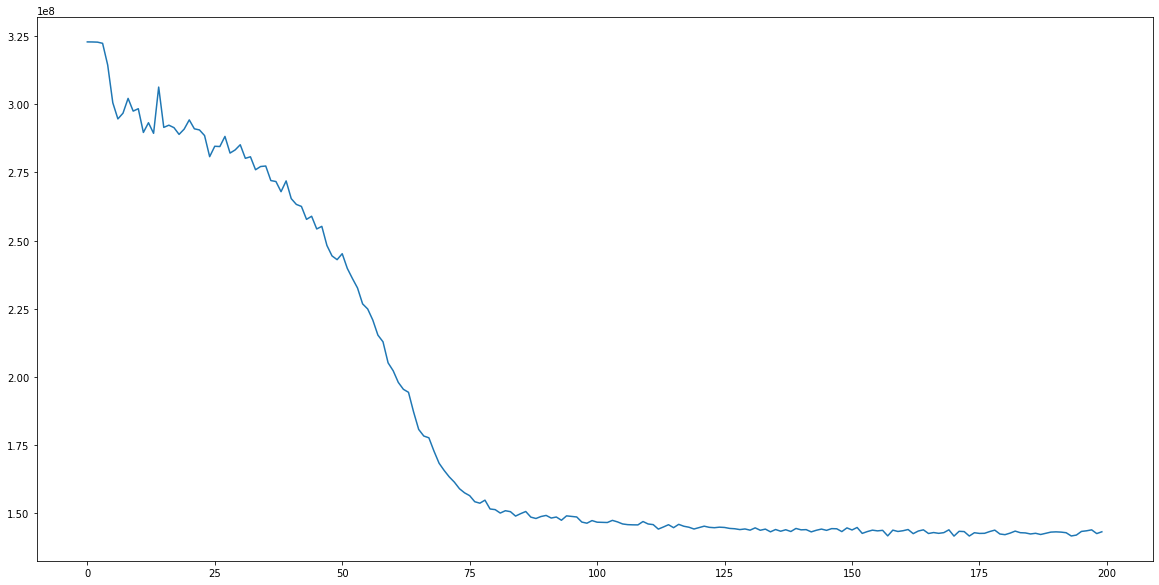

In [213]:
plt.plot(history.history['MSE'])


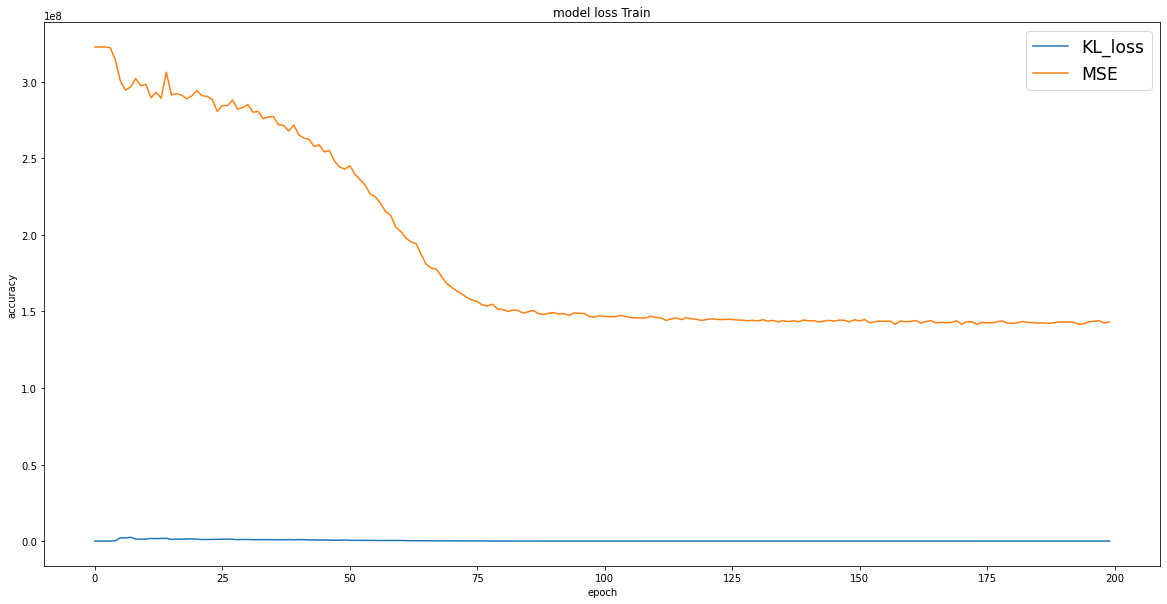

In [214]:
plt.plot(history.history['kl_loss'])
#plt.plot(history.history['val_total_loss'])
plt.title('model loss Train')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.plot(history.history['MSE'])
plt.legend(['KL_loss', 'MSE'], loc='upper right', fontsize ='xx-large')
plt.show()


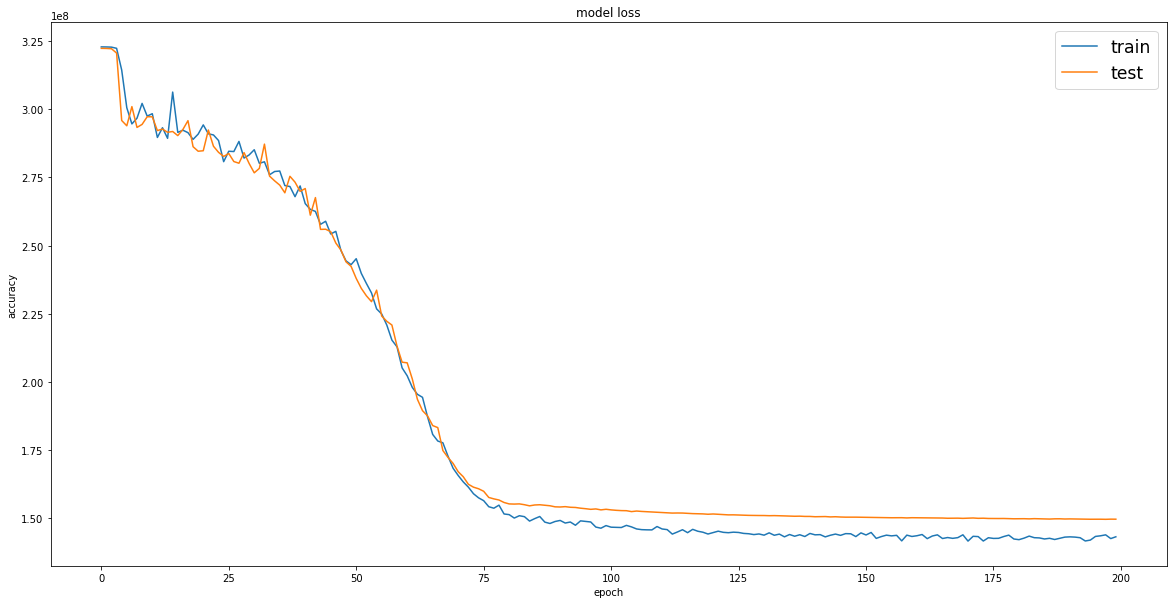

In [215]:
# summarize history for accuracy
plt.plot(history.history['MSE'])
#plt.plot(history.history['val_total_loss'])
plt.title('model loss')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.plot(history.history['val_MSE_val'])

plt.legend(['train', 'test'], loc='upper right', fontsize ='xx-large')
plt.show()


In [216]:
def nrmse(y_pred, y_test):
    
    num = tf.math.reduce_sum(tf.square(y_pred - y_test))
    num = num / y_test.shape[1]
    
    den = tf.math.reduce_sum(tf.square(y_test))/y_test.shape[1]
    
    return (num/den).numpy()

def mse(y_pred, y_test):
    
    num = tf.math.reduce_sum(tf.square(y_pred - y_test))
    num = num / y_test.shape[1]
    
    return num.numpy()

def mae(y_pred, y_test):
    
    num = tf.math.reduce_sum(tf.abs(y_pred - y_test))
    num = num / y_test.shape[1]
    
    return num.numpy()

print('NRMSE', nrmse(vae.predict(X_test), y_test.numpy()))
print('MAE', mae(vae.predict(X_test), y_test.numpy()))
print('RMSE', math.sqrt(mse(vae.predict(X_test), y_test.numpy())))
print('MSE', mse(vae.predict(X_test), y_test.numpy()))


IndexError: tuple index out of range

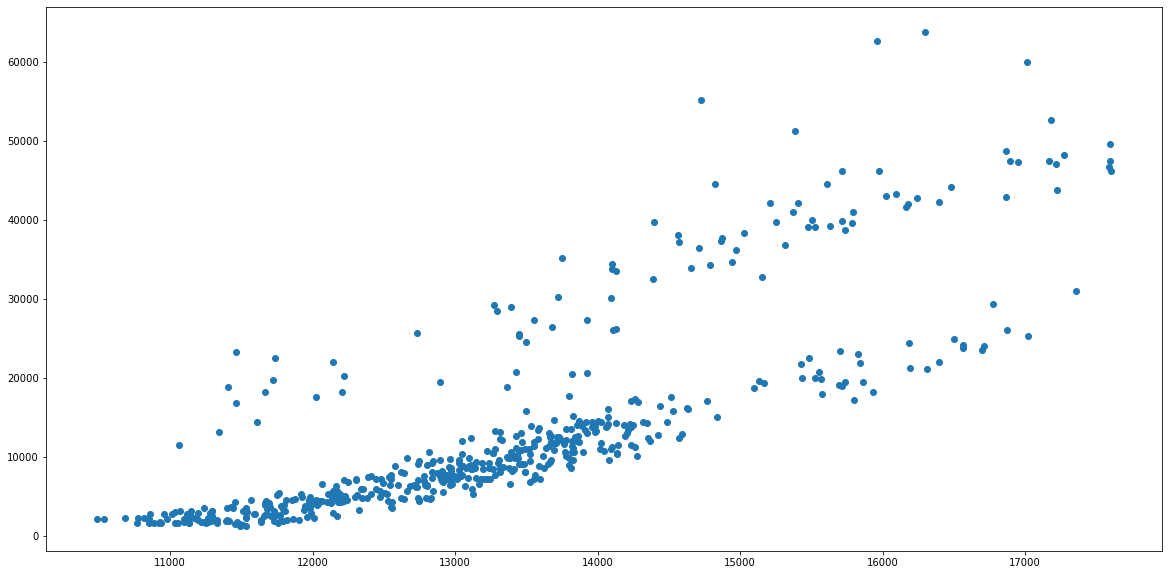

In [217]:
plt.scatter(vae.predict(X_test)[:], y_test[:])

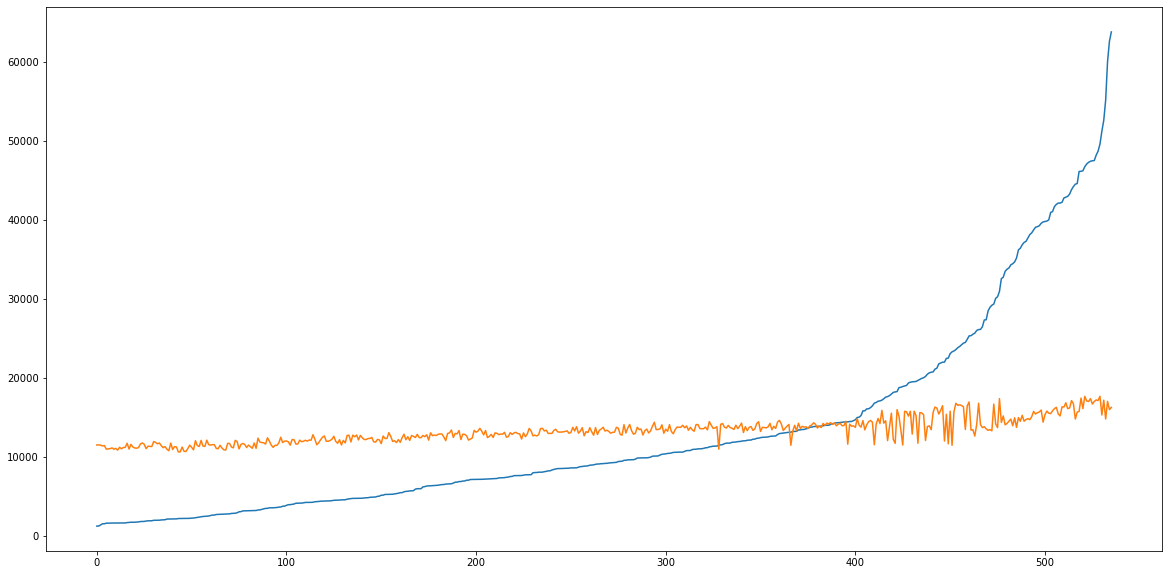

In [218]:
plt.plot(np.sort(y_test[:].numpy()))
plt.plot(vae.predict(X_test)[:][np.argsort(y_test[:].numpy())])

In [ ]:
vae.predict(X_test)

In [ ]:
y_test[:].numpy()